# Nb-20180314-1633-RandomForest-GainPrediction

In [1]:
STAMP = "20180314-1633"

This is a modification of the notebook Nb-20180314-1601.

Do a simple random forest to try to predict if a stock sticker will make a gain the next day.


Add in Open and low history (-1d, -2d, etc.)

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
from collections import defaultdict
import operator

In [4]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [5]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [6]:
import finance as fat

In [7]:
# Change the plot size.
plt.rcParams['figure.figsize'] = [18.0, 10.0]

In [8]:
ticker = 'IBM'

In [9]:
raw = fat.get_price_data(ticker)
ohlcv = raw

Loaded data for IBM: 1970-01-02 to 2018-03-12.


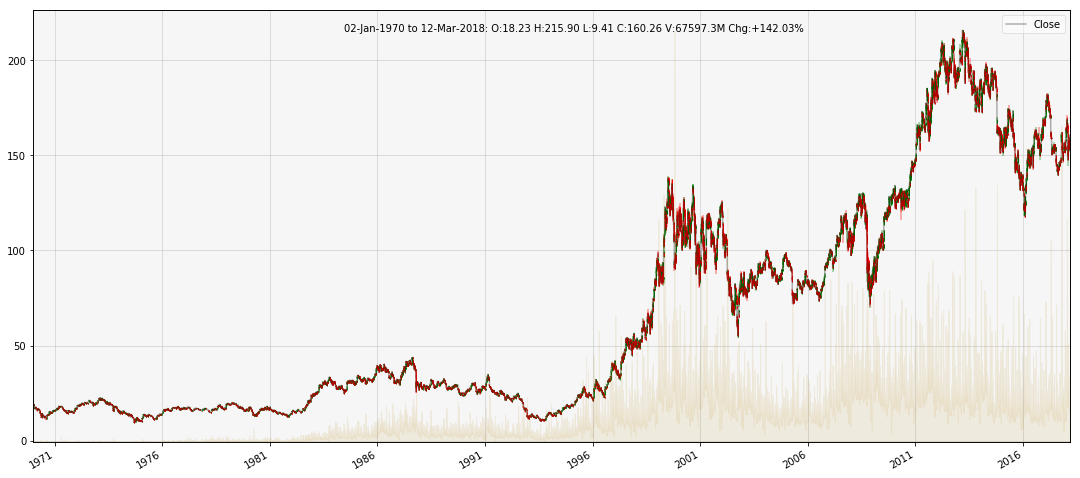

In [10]:
fat.plot_daily_ticker(ohlcv)

In [10]:
raw.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1970-01-02,18.225000,18.287500,18.200001,18.237499,1.689605,315200
1970-01-05,18.299999,18.412500,18.299999,18.412500,1.705818,424000
1970-01-06,18.412500,18.450001,18.312500,18.424999,1.706977,488000
1970-01-07,18.424999,18.437500,18.312500,18.437500,1.708133,457600
1970-01-08,18.437500,18.475000,18.375000,18.475000,1.711608,707200


### Price and Created Features

Scale the OHLC data to match 'Adj Close'

In [11]:
data = raw.copy()
data = data.div((data['Close']/data['Adj Close']), axis=0)
del data['Adj Close']
del data['Volume']
data.head()

,Open,High,Low,Close
Date,,,,
1970-01-02,1.688447,1.694237,1.686131,1.689605
1970-01-05,1.695395,1.705818,1.695395,1.705818
1970-01-06,1.705819,1.709293,1.696555,1.706977
1970-01-07,1.706975,1.708133,1.696552,1.708133
1970-01-08,1.708134,1.711608,1.702344,1.711608


Get table with prices for last 5 days, and price for following day.

In [12]:
for i in range(-5, 0, 1) :
    data[f'Close {i}d'] = data['Close'].shift(-i)
data = data.dropna()
data.head()

,Open,High,Low,Close,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d
Date,,,,,,,,,
1970-01-09,1.711607,1.716239,1.706975,1.709291,1.689605,1.705818,1.706977,1.708133,1.711608
1970-01-12,1.709292,1.712766,1.703502,1.703502,1.705818,1.706977,1.708133,1.711608,1.709291
1970-01-13,1.703502,1.741717,1.703502,1.733032,1.706977,1.708133,1.711608,1.709291,1.703502
1970-01-14,1.733032,1.739401,1.727821,1.731295,1.708133,1.711608,1.709291,1.703502,1.733032
1970-01-15,1.737085,1.767195,1.737085,1.767195,1.711608,1.709291,1.703502,1.733032,1.731295


In [13]:
for i in range(-5, 0, 1) :
    data[f'High {i}d'] = data['High'].shift(-i)
data = data.dropna()
data.head()

,Open,High,Low,Close,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,High -5d,High -4d,High -3d,High -2d,High -1d
Date,,,,,,,,,,,,,,
1970-01-16,1.767194,1.792671,1.709291,1.712765,1.709291,1.703502,1.733032,1.731295,1.767195,1.716239,1.712766,1.741717,1.739401,1.767195
1970-01-19,1.645020,1.645020,1.618964,1.621280,1.703502,1.733032,1.731295,1.767195,1.712765,1.712766,1.741717,1.739401,1.767195,1.792671
1970-01-20,1.621278,1.653704,1.598117,1.651388,1.733032,1.731295,1.767195,1.712765,1.621280,1.741717,1.739401,1.767195,1.792671,1.645020
1970-01-21,1.651388,1.651388,1.637492,1.644440,1.731295,1.767195,1.712765,1.621280,1.651388,1.739401,1.767195,1.792671,1.645020,1.653704
1970-01-22,1.644440,1.653704,1.640966,1.649072,1.767195,1.712765,1.621280,1.651388,1.644440,1.767195,1.792671,1.645020,1.653704,1.651388


In [14]:
for i in range(-5, 0, 1) :
    data[f'Low {i}d'] = data['Low'].shift(-i)
data = data.dropna()
data.head()

,Open,High,Low,Close,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,High -5d,High -4d,High -3d,High -2d,High -1d,Low -5d,Low -4d,Low -3d,Low -2d,Low -1d
Date,,,,,,,,,,,,,,,,,,,
1970-01-23,1.649072,1.662969,1.649072,1.649072,1.712765,1.621280,1.651388,1.644440,1.649072,1.792671,1.645020,1.653704,1.651388,1.653704,1.709291,1.618964,1.598117,1.637492,1.640966
1970-01-26,1.639808,1.639808,1.614331,1.614331,1.621280,1.651388,1.644440,1.649072,1.649072,1.645020,1.653704,1.651388,1.653704,1.662969,1.618964,1.598117,1.637492,1.640966,1.649072
1970-01-27,1.601592,1.601592,1.579589,1.599276,1.651388,1.644440,1.649072,1.649072,1.614331,1.653704,1.651388,1.653704,1.662969,1.639808,1.598117,1.637492,1.640966,1.649072,1.614331
1970-01-28,1.599277,1.608541,1.576116,1.579590,1.644440,1.649072,1.649072,1.614331,1.599276,1.651388,1.653704,1.662969,1.639808,1.601592,1.637492,1.640966,1.649072,1.614331,1.579589
1970-01-29,1.579590,1.596960,1.548322,1.568009,1.649072,1.649072,1.614331,1.599276,1.579590,1.653704,1.662969,1.639808,1.601592,1.608541,1.640966,1.649072,1.614331,1.579589,1.576116


In [15]:
for i in range(-5, 0, 1) :
    data[f'Open {i}d'] = data['Open'].shift(-i)
data = data.dropna()
data.head()

,Open,High,Low,Close,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,High -5d,...,Low -5d,Low -4d,Low -3d,Low -2d,Low -1d,Open -5d,Open -4d,Open -3d,Open -2d,Open -1d
Date,,,,,,,,,,,,,,,,,,,,,
1970-01-30,1.552664,1.596960,1.548321,1.552664,1.649072,1.614331,1.599276,1.579590,1.568009,1.662969,...,1.649072,1.614331,1.579589,1.576116,1.548322,1.649072,1.639808,1.601592,1.599277,1.579590
1970-02-02,1.561062,1.588855,1.561062,1.588855,1.614331,1.599276,1.579590,1.568009,1.552664,1.639808,...,1.614331,1.579589,1.576116,1.548322,1.548321,1.639808,1.601592,1.599277,1.579590,1.552664
1970-02-03,1.588853,1.606224,1.558744,1.590011,1.599276,1.579590,1.568009,1.552664,1.588855,1.601592,...,1.579589,1.576116,1.548322,1.548321,1.561062,1.601592,1.599277,1.579590,1.552664,1.561062
1970-02-04,1.590011,1.606224,1.558744,1.590011,1.579590,1.568009,1.552664,1.588855,1.590011,1.608541,...,1.576116,1.548322,1.548321,1.561062,1.558744,1.599277,1.579590,1.552664,1.561062,1.588853
1970-02-05,1.572641,1.572641,1.550638,1.569167,1.568009,1.552664,1.588855,1.590011,1.590011,1.596960,...,1.548322,1.548321,1.561062,1.558744,1.558744,1.579590,1.552664,1.561062,1.588853,1.590011


In [16]:
data = fat.add_sma_columns(data, 'Close', [6,12,20,200])

In [17]:
data = fat.add_ema_columns(data, 'Close', [3, 6, 12, 26, 50])

In [18]:
data = fat.add_bollinger_bands(data, 'Close')

In [19]:
scaled = data.div(data['Close'], axis=0)
scaled.head()

,Open,High,Low,Close,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,High -5d,...,Close SMA12,Close SMA20,Close SMA200,Close EMA3,Close EMA6,Close EMA12,Close EMA26,Close EMA50,Close BBandHi20,Close BBandLo20
Date,,,,,,,,,,,,,,,,,,,,,
1970-01-30,1.000000,1.028529,0.997203,1.0,1.062092,1.039717,1.030021,1.017342,1.009883,1.071042,...,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN
1970-02-02,0.982507,1.000000,0.982507,1.0,1.016034,1.006559,0.994169,0.986880,0.977222,1.032069,...,NaN,NaN,NaN,0.992407,0.990509,0.989560,0.989049,0.988839,NaN,NaN
1970-02-03,0.999272,1.010197,0.980335,1.0,1.005827,0.993446,0.986162,0.976511,0.999273,1.007284,...,NaN,NaN,NaN,0.996437,0.994379,0.993196,0.992523,0.992239,NaN,NaN
1970-02-04,1.000000,1.010197,0.980335,1.0,0.993446,0.986162,0.976511,0.999273,1.000000,1.011654,...,NaN,NaN,NaN,0.998337,0.996550,0.995344,0.994613,0.994297,NaN,NaN
1970-02-05,1.002214,1.002214,0.988192,1.0,0.999262,0.989483,1.012547,1.013283,1.013283,1.017712,...,NaN,NaN,NaN,1.005612,1.006353,1.006238,1.006010,1.005882,NaN,NaN


In [20]:
scaled = scaled.dropna()
scaled.head()

,Open,High,Low,Close,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,High -5d,...,Close SMA12,Close SMA20,Close SMA200,Close EMA3,Close EMA6,Close EMA12,Close EMA26,Close EMA50,Close BBandHi20,Close BBandLo20
Date,,,,,,,,,,,,,,,,,,,,,
1970-11-11,1.005887,1.019344,1.000000,1.0,0.996636,0.984440,0.989066,1.000840,1.005887,1.010934,...,0.994936,0.985804,0.963290,1.000321,0.998028,0.994067,0.984070,0.962442,1.015798,0.955811
1970-11-12,1.000421,1.004628,0.997055,1.0,0.984855,0.989483,1.001262,1.006311,1.000421,0.997896,...,0.997401,0.987112,0.963127,1.000371,0.998891,0.995334,0.985634,0.964304,1.017665,0.956558
1970-11-13,1.009808,1.009808,0.999574,1.0,1.002985,1.014924,1.020043,1.014072,1.013646,1.002985,...,1.010391,1.001186,0.975493,1.007011,1.008944,1.007544,0.999151,0.978347,1.031581,0.970790
1970-11-16,0.999574,1.000000,0.983802,1.0,1.014492,1.019608,1.013640,1.013214,0.999574,1.019607,...,1.008809,1.002446,0.974300,1.003291,1.006082,1.006020,0.998820,0.978796,1.028150,0.976742
1970-11-17,1.001280,1.008109,0.997866,1.0,1.020913,1.014938,1.014511,1.000854,1.001280,1.024328,...,1.009781,1.004228,0.974762,1.002288,1.005264,1.006184,1.000092,0.980832,1.029223,0.979233


In [21]:
del scaled['Close']
scaled.head()

,Open,High,Low,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,High -5d,High -4d,...,Close SMA12,Close SMA20,Close SMA200,Close EMA3,Close EMA6,Close EMA12,Close EMA26,Close EMA50,Close BBandHi20,Close BBandLo20
Date,,,,,,,,,,,,,,,,,,,,,
1970-11-11,1.005887,1.019344,1.000000,0.996636,0.984440,0.989066,1.000840,1.005887,1.010934,0.997476,...,0.994936,0.985804,0.963290,1.000321,0.998028,0.994067,0.984070,0.962442,1.015798,0.955811
1970-11-12,1.000421,1.004628,0.997055,0.984855,0.989483,1.001262,1.006311,1.000421,0.997896,0.989483,...,0.997401,0.987112,0.963127,1.000371,0.998891,0.995334,0.985634,0.964304,1.017665,0.956558
1970-11-13,1.009808,1.009808,0.999574,1.002985,1.014924,1.020043,1.014072,1.013646,1.002985,1.020042,...,1.010391,1.001186,0.975493,1.007011,1.008944,1.007544,0.999151,0.978347,1.031581,0.970790
1970-11-16,0.999574,1.000000,0.983802,1.014492,1.019608,1.013640,1.013214,0.999574,1.019607,1.023018,...,1.008809,1.002446,0.974300,1.003291,1.006082,1.006020,0.998820,0.978796,1.028150,0.976742
1970-11-17,1.001280,1.008109,0.997866,1.020913,1.014938,1.014511,1.000854,1.001280,1.024328,1.034571,...,1.009781,1.004228,0.974762,1.002288,1.005264,1.006184,1.000092,0.980832,1.029223,0.979233


### Volume and Created Features

In [22]:
vol = pd.DataFrame(raw, columns=['Volume'])
vol.head()

,Volume
Date,
1970-01-02,315200
1970-01-05,424000
1970-01-06,488000
1970-01-07,457600
1970-01-08,707200


In [23]:
# replace 0's, since they cause potential blow-ups
vol = vol.replace(0, 1)
vol.describe()

,Volume
count,1.215800e+04
mean,5.559903e+06
std,4.521317e+06
min,1.000000e+00
25%,2.415975e+06
50%,4.801200e+06
75%,7.404975e+06
max,6.944470e+07


In [24]:
for i in range(-5, 0, 1) :
    vol[f'Volume {i}d'] = vol['Volume'].shift(-i)
vol = vol.dropna()
vol.head()

,Volume,Volume -5d,Volume -4d,Volume -3d,Volume -2d,Volume -1d
Date,,,,,,
1970-01-09,585600,315200.0,424000.0,488000.0,457600.0,707200.0
1970-01-12,379200,424000.0,488000.0,457600.0,707200.0,585600.0
1970-01-13,744000,488000.0,457600.0,707200.0,585600.0,379200.0
1970-01-14,392000,457600.0,707200.0,585600.0,379200.0,744000.0
1970-01-15,420800,707200.0,585600.0,379200.0,744000.0,392000.0


In [25]:
vol = vol.div(vol['Volume'], axis=0)
vol.head()

,Volume,Volume -5d,Volume -4d,Volume -3d,Volume -2d,Volume -1d
Date,,,,,,
1970-01-09,1.0,0.538251,0.724044,0.833333,0.781421,1.207650
1970-01-12,1.0,1.118143,1.286920,1.206751,1.864979,1.544304
1970-01-13,1.0,0.655914,0.615054,0.950538,0.787097,0.509677
1970-01-14,1.0,1.167347,1.804082,1.493878,0.967347,1.897959
1970-01-15,1.0,1.680608,1.391635,0.901141,1.768061,0.931559


In [26]:
del vol['Volume']
vol.head()

,Volume -5d,Volume -4d,Volume -3d,Volume -2d,Volume -1d
Date,,,,,
1970-01-09,0.538251,0.724044,0.833333,0.781421,1.207650
1970-01-12,1.118143,1.286920,1.206751,1.864979,1.544304
1970-01-13,0.655914,0.615054,0.950538,0.787097,0.509677
1970-01-14,1.167347,1.804082,1.493878,0.967347,1.897959
1970-01-15,1.680608,1.391635,0.901141,1.768061,0.931559


In [27]:
vol.describe()

,Volume -5d,Volume -4d,Volume -3d,Volume -2d,Volume -1d
count,1.215300e+04,1.215300e+04,1.215300e+04,1.215300e+04,1.215300e+04
mean,2.835225e+02,5.300415e+02,5.406329e+02,4.159110e+02,3.990648e+02
std,1.875804e+04,3.557069e+04,3.972874e+04,2.877679e+04,2.986084e+04
min,1.634949e-07,2.906301e-07,2.687016e-07,2.021182e-07,1.373551e-07
25%,7.537879e-01,7.563497e-01,7.643649e-01,7.783741e-01,8.045977e-01
50%,1.010152e+00,1.012238e+00,1.006932e+00,1.012800e+00,1.012804e+00
75%,1.337820e+00,1.331903e+00,1.323700e+00,1.312066e+00,1.262325e+00
max,1.590400e+06,2.911200e+06,3.924800e+06,2.710000e+06,3.030400e+06


### Join Price and Volume

In [28]:
scaled = scaled.join(vol, how='outer')

In [29]:
scaled['Gain +1d'] = scaled['Close -1d'].shift(-1) < 1.0
scaled.head()

,Open,High,Low,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,High -5d,High -4d,...,Close EMA26,Close EMA50,Close BBandHi20,Close BBandLo20,Volume -5d,Volume -4d,Volume -3d,Volume -2d,Volume -1d,Gain +1d
Date,,,,,,,,,,,,,,,,,,,,,
1970-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.538251,0.724044,0.833333,0.781421,1.207650,False
1970-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.118143,1.286920,1.206751,1.864979,1.544304,False
1970-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.655914,0.615054,0.950538,0.787097,0.509677,False
1970-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.167347,1.804082,1.493878,0.967347,1.897959,False
1970-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.680608,1.391635,0.901141,1.768061,0.931559,False


In [30]:
scaled = scaled.dropna()
scaled.head().T

Date,1970-11-11 00:00:00,1970-11-12 00:00:00,1970-11-13 00:00:00,1970-11-16 00:00:00,1970-11-17 00:00:00
Open,1.00589,1.00042,1.00981,0.999574,1.00128
High,1.01934,1.00463,1.00981,1,1.00811
Low,1,0.997055,0.999574,0.983802,0.997866
Close -5d,0.996636,0.984855,1.00298,1.01449,1.02091
Close -4d,0.98444,0.989483,1.01492,1.01961,1.01494
Close -3d,0.989066,1.00126,1.02004,1.01364,1.01451
Close -2d,1.00084,1.00631,1.01407,1.01321,1.00085
Close -1d,1.00589,1.00042,1.01365,0.999574,1.00128
High -5d,1.01093,0.997896,1.00298,1.01961,1.02433
High -4d,0.997476,0.989483,1.02004,1.02302,1.03457


In [31]:
scaled.describe()

,Open,High,Low,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,High -5d,High -4d,...,Close EMA12,Close EMA26,Close EMA50,Close BBandHi20,Close BBandLo20,Volume -5d,Volume -4d,Volume -3d,Volume -2d,Volume -1d
count,11939.000000,11939.000000,11939.000000,11939.000000,11939.000000,11939.000000,11939.000000,11939.000000,11939.000000,11939.000000,...,11939.000000,11939.000000,11939.000000,11939.000000,11939.000000,1.193900e+04,1.193900e+04,1.193900e+04,1.193900e+04,1.193900e+04
mean,0.999963,1.009517,0.990677,0.998645,0.998917,0.999190,0.999465,0.999736,1.008128,1.008403,...,0.998516,0.996620,0.993296,1.047683,0.947192,2.885841e+02,5.395218e+02,5.503033e+02,4.233457e+02,4.061981e+02
std,0.013752,0.009934,0.009491,0.035502,0.031803,0.027622,0.022791,0.016328,0.036705,0.033094,...,0.025346,0.039073,0.054661,0.053030,0.047987,1.892539e+04,3.588803e+04,4.008318e+04,2.903352e+04,3.012725e+04
min,0.885073,1.000000,0.885073,0.794521,0.804176,0.818940,0.841140,0.883676,0.800708,0.808815,...,0.877461,0.831490,0.788588,0.944961,0.651485,1.634949e-07,2.906301e-07,2.687016e-07,2.021182e-07,1.373551e-07
25%,0.992838,1.003084,0.987498,0.979382,0.981451,0.984325,0.987521,0.991579,0.987628,0.989662,...,0.984343,0.973757,0.959105,1.015616,0.926162,7.542518e-01,7.572288e-01,7.649512e-01,7.788312e-01,8.048747e-01
50%,1.000000,1.006977,0.993380,0.998179,0.998833,0.999036,0.999640,1.000000,1.006402,1.006994,...,0.997905,0.995069,0.990714,1.033581,0.959077,1.010144e+00,1.011644e+00,1.006479e+00,1.012844e+00,1.013397e+00
75%,1.007136,1.012938,0.997117,1.016911,1.015343,1.013334,1.010996,1.007919,1.026163,1.024684,...,1.011661,1.017186,1.022384,1.062546,0.980333,1.336681e+00,1.330549e+00,1.323069e+00,1.311547e+00,1.262084e+00
max,1.307506,1.336562,1.000000,1.447942,1.440678,1.406779,1.357143,1.307507,1.464891,1.467312,...,1.357905,1.433618,1.483393,1.668282,1.205084,1.590400e+06,2.911200e+06,3.924800e+06,2.710000e+06,3.030400e+06


### Initial processing

In [32]:
scaled = scaled.reset_index()
scaled.head()

,Date,Open,High,Low,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,High -5d,...,Close EMA26,Close EMA50,Close BBandHi20,Close BBandLo20,Volume -5d,Volume -4d,Volume -3d,Volume -2d,Volume -1d,Gain +1d
0,1970-11-11,1.005887,1.019344,1.000000,0.996636,0.984440,0.989066,1.000840,1.005887,1.010934,...,0.984070,0.962442,1.015798,0.955811,0.572289,0.688755,0.718876,1.144578,0.843373,False
1,1970-11-12,1.000421,1.004628,0.997055,0.984855,0.989483,1.001262,1.006311,1.000421,0.997896,...,0.985634,0.964304,1.017665,0.956558,0.714583,0.745833,1.187500,0.875000,1.037500,False
2,1970-11-13,1.009808,1.009808,0.999574,1.002985,1.014924,1.020043,1.014072,1.013646,1.002985,...,0.999151,0.978347,1.031581,0.970790,0.848341,1.350711,0.995261,1.180095,1.137441,True
3,1970-11-16,0.999574,1.000000,0.983802,1.014492,1.019608,1.013640,1.013214,0.999574,1.019607,...,0.998820,0.978796,1.028150,0.976742,1.170431,0.862423,1.022587,0.985626,0.866530,False
4,1970-11-17,1.001280,1.008109,0.997866,1.020913,1.014938,1.014511,1.000854,1.001280,1.024328,...,1.000092,0.980832,1.029223,0.979233,1.680000,1.992000,1.920000,1.688000,1.948000,False


In [33]:
add_datepart(scaled, 'Date')
del scaled['Elapsed']
del scaled['Year']
scaled.head()

,Open,High,Low,Close -5d,Close -4d,Close -3d,Close -2d,Close -1d,High -5d,High -4d,...,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,1.005887,1.019344,1.000000,0.996636,0.984440,0.989066,1.000840,1.005887,1.010934,0.997476,...,46,11,2,315,False,False,False,False,False,False
1,1.000421,1.004628,0.997055,0.984855,0.989483,1.001262,1.006311,1.000421,0.997896,0.989483,...,46,12,3,316,False,False,False,False,False,False
2,1.009808,1.009808,0.999574,1.002985,1.014924,1.020043,1.014072,1.013646,1.002985,1.020042,...,46,13,4,317,False,False,False,False,False,False
3,0.999574,1.000000,0.983802,1.014492,1.019608,1.013640,1.013214,0.999574,1.019607,1.023018,...,47,16,0,320,False,False,False,False,False,False
4,1.001280,1.008109,0.997866,1.020913,1.014938,1.014511,1.000854,1.001280,1.024328,1.034571,...,47,17,1,321,False,False,False,False,False,False


The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

In [34]:
scaled.tail().T

,11934,11935,11936,11937,11938
Open,1.01002,0.97903,1.01786,0.98845,0.996131
High,1.01394,1.00322,1.02151,1.00169,1.00474
Low,0.996404,0.977324,0.992702,0.987383,0.991327
Close -5d,1.00533,0.984272,0.984636,0.969745,0.979346
Close -4d,1.00071,0.971513,0.988989,0.985186,0.971671
Close -3d,0.987734,0.975808,1.00474,0.977465,0.987895
Close -2d,0.992101,0.991347,0.996863,0.993786,0.974729
Close -1d,1.0079,0.983578,1.01351,0.980541,0.994072
High -5d,1.02607,0.998863,1.00487,0.971439,0.982716
High -4d,1.01554,0.991473,0.990718,0.988576,0.985212


In [35]:
train_cats(scaled)

But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

In [36]:
file_name = f'data/tmp/{ticker}-{STAMP}-gain-raw'

In [37]:
os.makedirs('data/tmp', exist_ok=True)
scaled.to_feather(file_name)

### Pre-processing

In the future we can simply read it from this fast format.

In [38]:
df_raw = pd.read_feather(file_name)

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [39]:
dep_col = 'Gain +1d'

In [40]:
df, y, nas = proc_df(df_raw, dep_col)

In [41]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

In [42]:
len(df_raw)

11939

In [43]:
n_valid = int(len(df_raw)*.2)  # 20% of samples 
n_trn = len(df_raw)-n_valid
raw_train, raw_valid = split_vals(df, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((9552, 50), (9552,), (2387, 50))

# Random Forests

## Base model

Let's try our model again, this time with separate training and validation sets.

In [44]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## Single tree

In [45]:
m = RandomForestClassifier(n_estimators=1, max_depth=4, bootstrap=False, n_jobs=-1, random_state=42, min_samples_leaf=10)
m.fit(X_train, y_train)
print_score(m)

[0.5466917922948074, 0.5060745705906996]


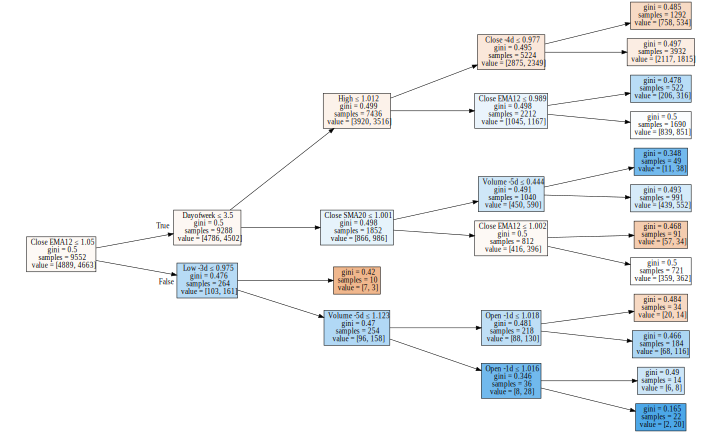

In [46]:
draw_tree(m.estimators_[0], raw_train, precision=3)

In [47]:
y_pred = m.predict(X_valid)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[799, 369],
       [810, 409]], dtype=int64)

## Bagging

In [48]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=20, max_features='sqrt', n_jobs=-1, oob_score=True, random_state=42)
m.fit(X_train, y_train)
print_score(m)

[0.8697654941373534, 0.4997905320485966, 0.5254396984924623]


In [49]:
y_pred = m.predict(X_valid)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[766, 402],
       [792, 427]], dtype=int64)

In [50]:
def plot_metrics(metrics): return metrics.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [51]:
def get_metrics(stamp, y_valid, y_pred, chance) :
    col = ['accuracy', 'precision','recall','f1','chance']
    val = []
    val.append(metrics.accuracy_score(y_valid, y_pred))
    val.append(metrics.precision_score(y_valid, y_pred))
    val.append(metrics.recall_score(y_valid, y_pred))
    val.append(metrics.f1_score(y_valid, y_pred))
    val.append(chance)
    
    return pd.DataFrame(data=[val], columns=col, index=[stamp])

In [52]:
# Percent of true gains over all samples: compare to precision -- precision should be signficantly higher if this is a useful
# prediction
# (cnf_matrix[1,0] + cnf_matrix[1,1]) / cnf_matrix.sum() 
chance = cnf_matrix[1:].sum() / cnf_matrix.sum()

In [53]:
met = get_metrics(STAMP, y_valid, y_pred, chance)

,accuracy,precision,recall,f1,chance
20180314-1633,0.499791,0.515078,0.350287,0.416992,0.510683


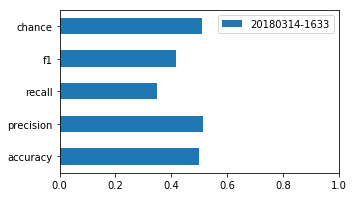

In [54]:
met.T.plot(kind='barh', figsize=(5,3), xlim=(0,1))
met

In [55]:
fi = rf_feat_importance(m, df)

In [56]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,8), legend=False)

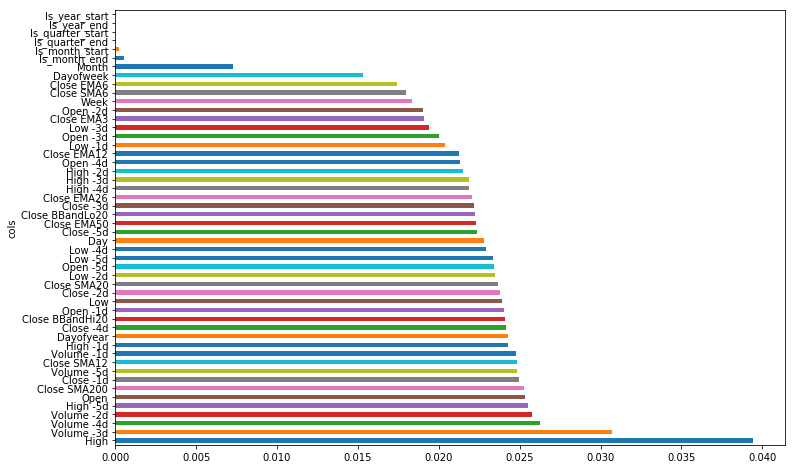

In [57]:
plot_fi(fi)

Some things to try: 
- Add in OHL booleans such as: OpenHigherThanPreviousClose, OpenLowerThanPreviousClose, CloseIsHigh, CloseIsLow, OpenIsHigh, OpenIsLow
- Add in OHL history (-1d, -2d, etc.)
- Add in "Bollinger Band" with +/-1 STD (in addition to standard BBand which is +/-2 STD)